In [1]:
%load_ext autoreload
%autoreload 2

# Noiseless

## Simulation settings

In [2]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB

L_arr = [8, 16, 24, 32]
# L_arr = [16]
J = 1
h = 0.05
lamb = 0.7
g = None

x_basis = False

particle_pair_left_positions = [L//2 - 1 for L in L_arr]
particle_pair_length = 1

final_time = 8
steps = 35

shots = [50000]

execution_database = "z2_chain_jobs_postselection.json"
jobs_result_folder = execution_database.split(".")[0] + "/"
job_db = ExecDB(execution_database)

circ_folder_path = "Circuits/"

## Circuit generation & observables

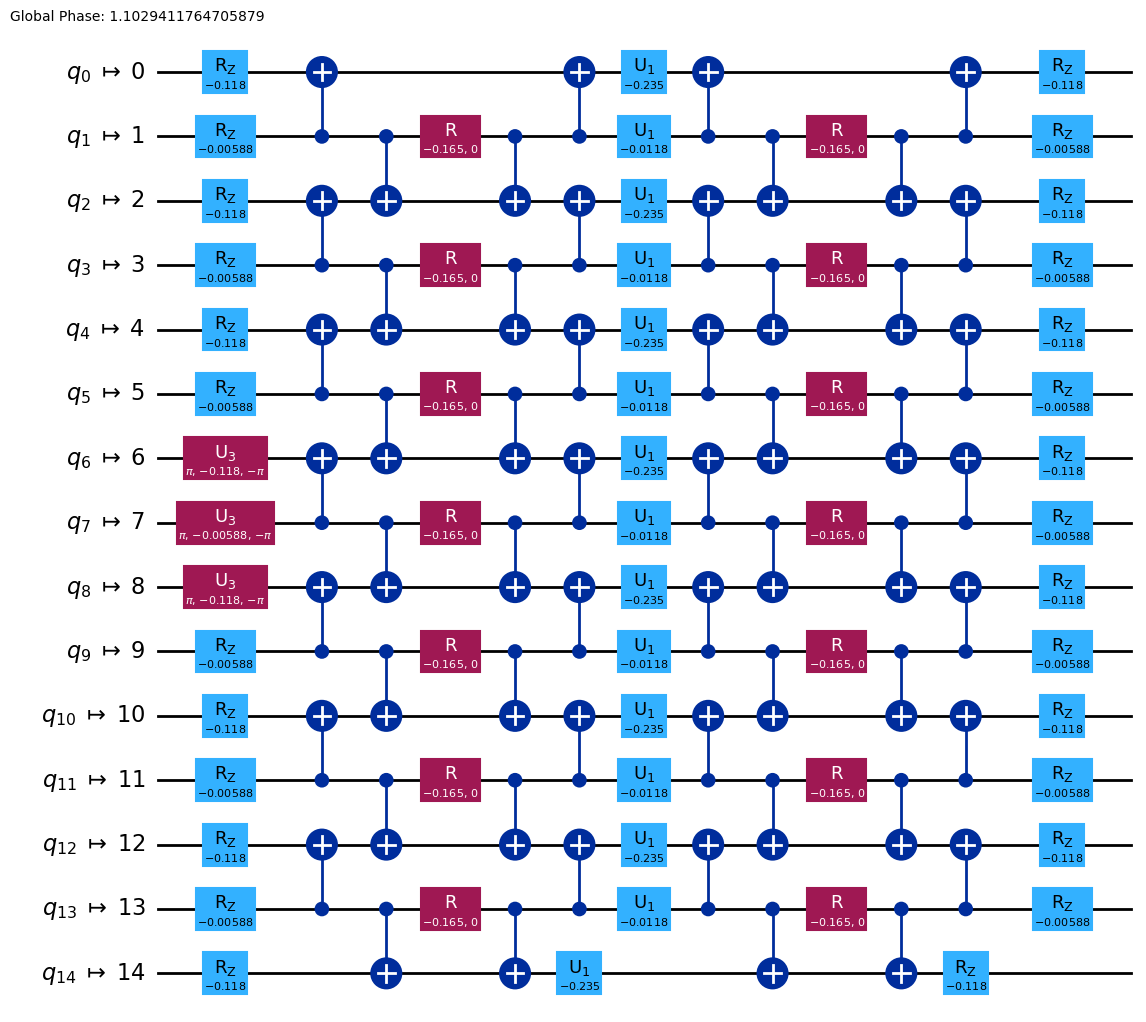

In [3]:
from z2chain.circs import erradj_particle_pair_quench_simulation_circuits
from z2chain.operators import local_pauli_x, local_pauli_z
from utils.circs import generate_and_save_circs
from qiskit_aer import AerSimulator
from functools import partial
import numpy as np
import os

optimization_level = 2

circuits = [] # circuits[L][t]
observable_generating_funcs = [] #observable_generating_funcs[L][i]
postselection_operators_funcs = []

estimator_options = [{
    "default_precision": 0
}]

simulator_options = [{
    "method": "matrix_product_state",
    "matrix_product_state_max_bond_dimension": 256,
    "matrix_product_state_truncation_threshold": 1e-10
}]

backend = AerSimulator(**simulator_options[0])

eplg_absolute = 2e-3

for L, pp_ps in zip(L_arr, particle_pair_left_positions):
    circuit_filepath = os.path.join(circ_folder_path, f"z2chain_quench_circs_simulation_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.qpy")
    qubits_inds = np.arange(2*L-1)
    circs_func_args = (L, J, h, lamb, pp_ps, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g, qubits_inds, x_basis)
    circuit = generate_and_save_circs(circuit_filepath, erradj_particle_pair_quench_simulation_circuits, *circs_func_args)
    circuits.append(circuit)

circuits[0][1].draw(output="mpl", idle_wires=False)

## Simulation

In [ ]:
from z2chain.plotting import load_site_gauge_observable_matrix, save_site_gauge_observable_matrix
from utils.sexec import execute_simulation_estimator_batch

jobs = []

for i, L in enumerate(L_arr):
    this_L_jobs = []
    for estimator_opt, simulator_opt in zip(estimator_options, simulator_options):
        filepath = f"Results/tncirc_z2pairquench_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_xbasis_{x_basis}_bd_{simulator_options["matrix_product_state_max_bond_dimension"]}_prec_{estimator_opt['default_precision']}.txt"
        if os.path.exists(filepath):
            this_jobs = load_site_gauge_observable_matrix(filepath)
        else:
            observable_generating_funcs = [partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)]
            this_jobs = execute_simulation_estimator_batch(simulator_opt, estimator_opt, circuits[i], observable_generating_funcs)
            save_site_gauge_observable_matrix(this_jobs, filepath)
        this_L_jobs.append(this_jobs)
    jobs.append(this_L_jobs)

## Plots

In [ ]:
from z2chain.plotting import x_t_plot

for i, L in enumerate(L_arr):
    for j, (estimator_opt, simulator_opt) in enumerate(zip(estimator_options, simulator_options)):
        occupations = (1 - jobs[i][j])/2
        x_t_plot(occupations, filepath=f"Plots/tncirc_z2pairquench_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_xbasis_{x_basis}_bd_{simulator_options["matrix_product_state_max_bond_dimension"]}_prec_{estimator_opt['default_precision']}.txt")